##Survival Analysis

In this Google colab notebook we are going to take a look at how we can build a survival modeling of a Telco customer churn 

### Import all the libararies and the CSV File

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/archive/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()
print(list(df.columns))

['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [ ]:
df["Churn"].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [ ]:
### Visualizing the CSV file in different catagories

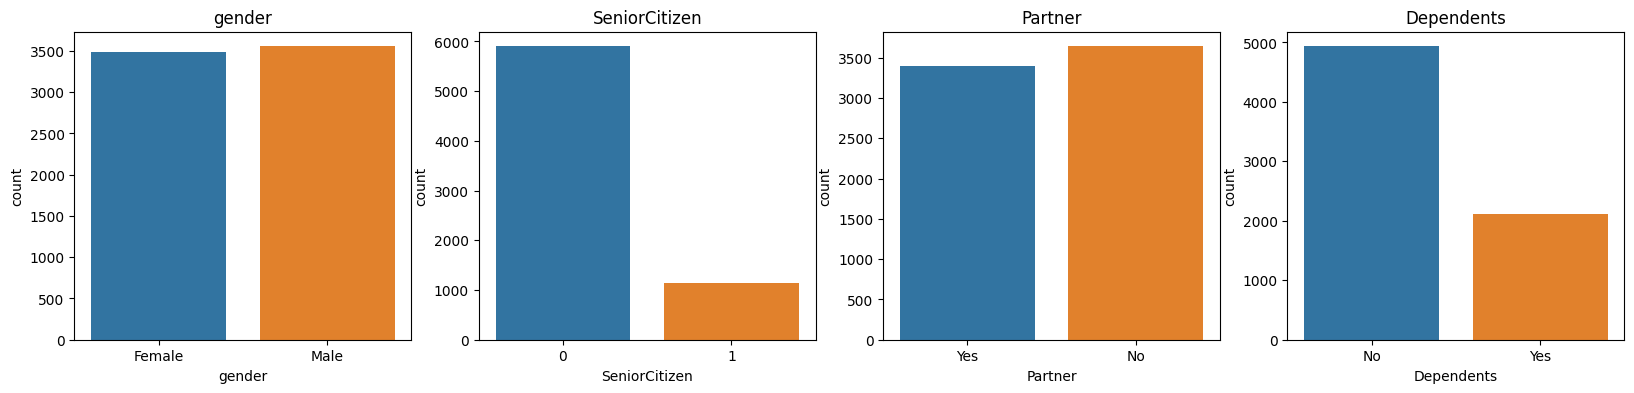

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

cols = ['gender','SeniorCitizen',"Partner","Dependents"]
numerical = cols

plt.figure(figsize=(20,4))

for i, col in enumerate(numerical):
    ax = plt.subplot(1, len(numerical), i+1)
    sns.countplot(x=str(col), data=df)
    ax.set_title(f"{col}")

<Axes: xlabel='Churn', ylabel='MonthlyCharges'>

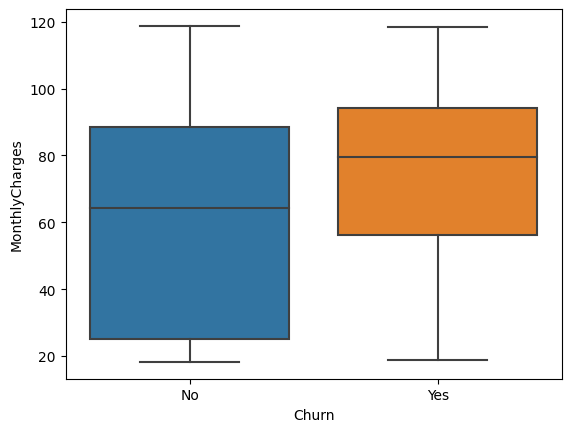

In [ ]:
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)


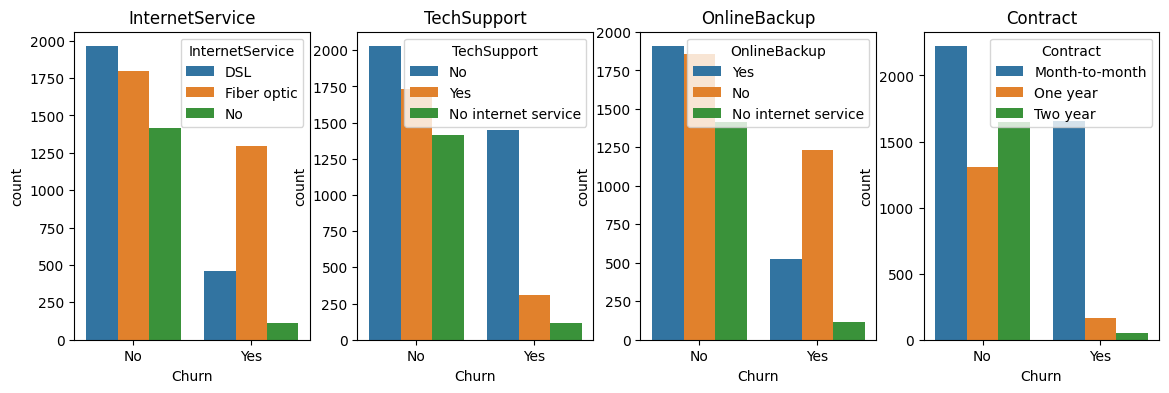

In [ ]:
cols = ['InternetService',"TechSupport","OnlineBackup","Contract"]

plt.figure(figsize=(14,4))

for i, col in enumerate(cols):
    ax = plt.subplot(1, len(cols), i+1)
    sns.countplot(x ="Churn", hue = str(col), data = df)
    ax.set_title(f"{col}")


In [ ]:
df['TotalCharges'] = df['TotalCharges'].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()


In [ ]:
cat_features = df.drop(['customerID','TotalCharges','MonthlyCharges','SeniorCitizen','tenure'],axis=1)

cat_features.head()

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
2,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
3,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No
4,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes


## Building the model and testing them for Telco dataset using the  Kaplan Meier Method and Cox Proportional Hazards model

      Churn  tenure  MonthlyCharges  gender  SeniorCitizen
0         0       1           29.85       0              0
1         0      34           56.95       1              0
2         1       2           53.85       1              0
3         0      45           42.30       1              0
4         1       2           70.70       0              0
...     ...     ...             ...     ...            ...
7038      0      24           84.80       1              0
7039      0      72          103.20       0              0
7040      0      11           29.60       0              0
7041      1       4           74.40       1              1
7042      0      66          105.65       1              0

[7032 rows x 5 columns]


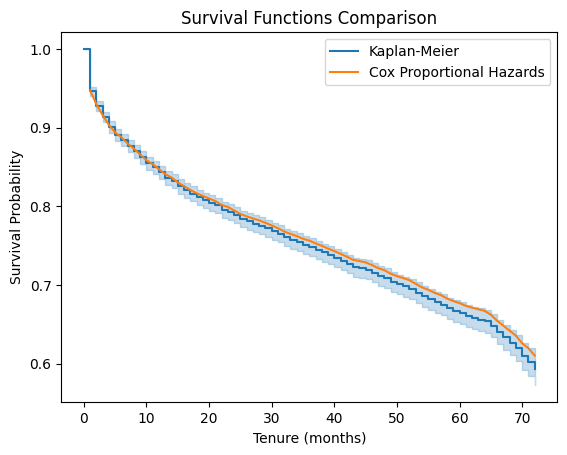

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/archive/WA_Fn-UseC_-Telco-Customer-Churn.csv')
# Preprocess the data correctly
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)
df = df.dropna()
df = df[['Churn', 'tenure', 'MonthlyCharges', 'gender', 'SeniorCitizen']]
print(df)
# Kaplan Meier Method
kmf = KaplanMeierFitter()
kmf.fit(df['tenure'], event_observed=df['Churn'])
# Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(df, duration_col='tenure', event_col='Churn')
average_survival_cph = cph.predict_survival_function(df).mean(axis=1)
kmf.plot_survival_function(label='Kaplan-Meier')
plt.plot(average_survival_cph.index, average_survival_cph.values, label='Cox Proportional Hazards')
plt.title("Survival Functions Comparison")
plt.xlabel("Tenure (months)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()


#### Determinging the RMSE and MAE

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
kmf_pred = kmf.predict(df['tenure']).values
cph_pred = cph.predict_survival_function(df).T.mean(axis=1).values
rmse_kmf = np.sqrt(mean_squared_error(df['Churn'], 1 - kmf_pred))
rmse_cph = np.sqrt(mean_squared_error(df['Churn'], 1 - cph_pred))
mae_kmf = mean_absolute_error(df['Churn'], 1 - kmf_pred)
mae_cph = mean_absolute_error(df['Churn'], 1 - cph_pred)
print(f"RMSE Error for KMF:{rmse_kmf}")
print(f"RMSE Error for CPH:{rmse_cph}")
print(f"MAE Error for KMF:{mae_kmf}")
print(f"MAE Error for CPH:{mae_cph}")


RMSE Error for KMF:0.49387630886567196
RMSE Error for CPH:0.4344650497476844
MAE Error for KMF:0.4079094948125434
MAE Error for CPH:0.36843875874248694


### Building the model for LogisticRegression and SVC as bulding more models are causing issues google colab notebook

Training Logistic Regression...
RMSE: 0.4245817881386584
MAE: 0.18026969481902058




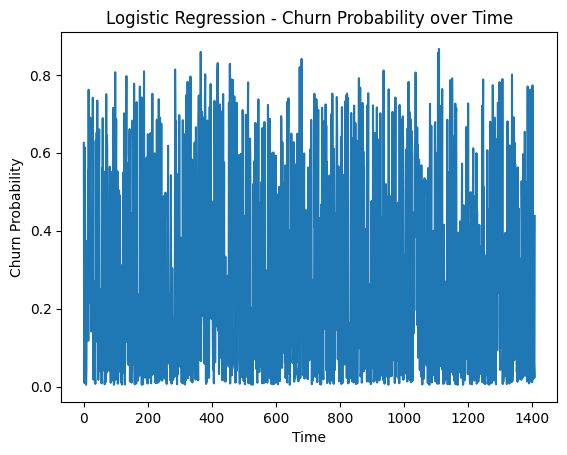

Training Support Vector Machine...
RMSE: 0.44498626385287793
MAE: 0.1980127750177431




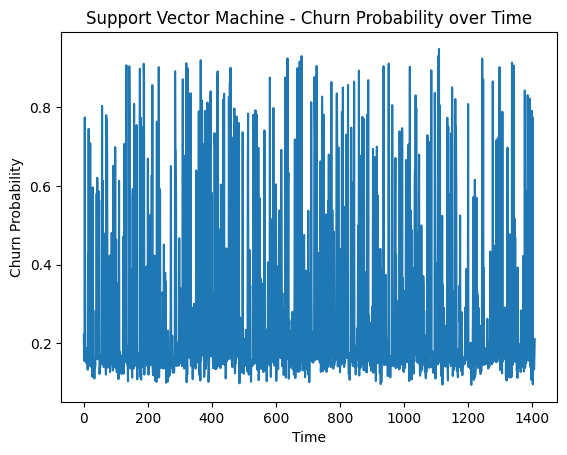

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/archive/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Drop unnecessary columns
df = df.drop(['customerID', 'TotalCharges'], axis=1)

# Encode the target variable
encoder = LabelEncoder()
df['Churn'] = encoder.fit_transform(df['Churn'])

# Split into features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing pipeline
preprocessing = make_column_transformer(
    (OneHotEncoder(), ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']),
    remainder='passthrough')

# Define models
models = {
    'Logistic Regression': make_pipeline(preprocessing, LogisticRegression(max_iter=1000)),
    'Support Vector Machine': make_pipeline(preprocessing, SVC(probability=True))
}

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of positive class (churn)

    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    mae = mean_absolute_error(y_test, y_pred)

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print("\n")

    # Create a DataFrame with actual churn values and predicted churn probabilities
    churn_df = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred_proba})
    churn_df['Time'] = range(len(churn_df))

    # Plot the churn probability over time
    plt.figure()
    plt.title(f"{name} - Churn Probability over Time")
    sns.lineplot(x='Time', y='Predicted', data=churn_df)
    plt.xlabel("Time")
    plt.ylabel("Churn Probability")
    plt.show()


## Determining the C-index and Log-rank p- value for the models to prove that for survival anlysis RMSE and MAE is not the only factor in determining the better model.

      Churn  tenure  MonthlyCharges  gender  SeniorCitizen
0         0       1           29.85       0              0
1         0      34           56.95       1              0
2         1       2           53.85       1              0
3         0      45           42.30       1              0
4         1       2           70.70       0              0
...     ...     ...             ...     ...            ...
7038      0      24           84.80       1              0
7039      0      72          103.20       0              0
7040      0      11           29.60       0              0
7041      1       4           74.40       1              1
7042      0      66          105.65       1              0

[7032 rows x 5 columns]
Kaplan-Meier C-Index: 0.9888254298936076
Cox Proportional Hazards C-Index: 0.5511228855420562
Kaplan-Meier Log-Rank p-value: [5.35025472e-244]


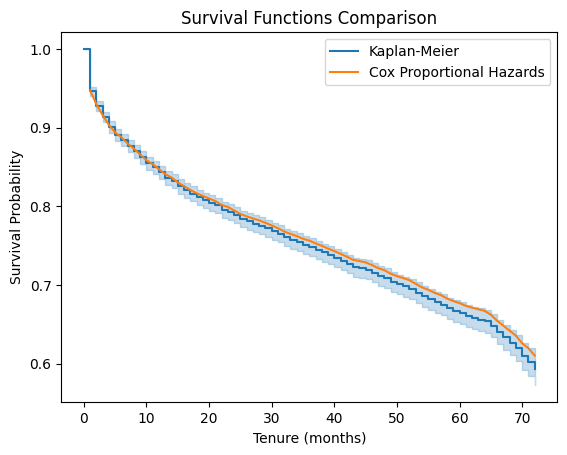

In [ ]:
import lifelines.statistics as stat

from lifelines.utils import concordance_index

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/archive/WA_Fn-UseC_-Telco-Customer-Churn.csv')
# Preprocess the data correctly
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)
df = df.dropna()
df = df[['Churn', 'tenure', 'MonthlyCharges', 'gender', 'SeniorCitizen']]
print(df)
# Kaplan Meier Method
kmf = KaplanMeierFitter()
kmf.fit(df['tenure'], event_observed=df['Churn'])

# Calculate C-index for Kaplan-Meier
c_index_kmf = concordance_index(df['tenure'], -kmf.predict(df['tenure']), df['Churn'])
print(f"Kaplan-Meier C-Index: {c_index_kmf}")
# Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(df, duration_col='tenure', event_col='Churn')

# Calculate C-index for Cox Proportional Hazards
cph_c_index = cph.concordance_index_
print(f"Cox Proportional Hazards C-Index: {cph_c_index}")

# Perform log-rank test for Kaplan-Meier
kmf_survival_prob = kmf.predict(df['tenure'])
kmf_results = stat.pairwise_logrank_test(df['tenure'], df['Churn'], kmf_survival_prob)
kmf_log_rank_p_value = kmf_results.p_value
print(f"Kaplan-Meier Log-Rank p-value: {kmf_log_rank_p_value}")


# Plot survival functions
average_survival_cph = cph.predict_survival_function(df).mean(axis=1)
kmf.plot_survival_function(label='Kaplan-Meier')
plt.plot(average_survival_cph.index, average_survival_cph.values, label='Cox Proportional Hazards')
plt.title("Survival Functions Comparison")
plt.xlabel("Tenure (months)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()


## End of notebook